<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/time_series_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Preamble
---

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/NotAndex/Demo/blob/main/time_series_feature_engineering.ipynb"><img src="https://github.com/NotAndex/Demo/blob/main/images/GitHub-Mark-32px.png?raw=true" />View this code on GitHub.com</a>
  </td>

  <td>
    <a target="_blank" href="https://github.com/NotAndex/Demo/blob/main/scientific_sources.md"><img src="https://github.com/NotAndex/Demo/blob/main/images/GitHub-Mark-32px.png?raw=true" />View scientific sources on GitHub.com</a>
  </td>


</table>


# 1 Setup
---


In [71]:
!pip install yfinance
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime

from tensorflow.keras.utils import to_categorical

import IPython
import IPython.display
IPython.display.clear_output()

# 2 Data
---

In [ ]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365)
symbol = 'BTC-USD'

cc_data = yf.download(symbol, start=start_date, end=today)
cc_data.reset_index(inplace=True,col_fill=('Date'))

#3 Feature engineering
---

In regards to Bitcoin data, Jaquart et al. (2020) defined five feature categories: 
* Technical features
* Asset-based features
* Blockchain-based features
* Sentiment- and interest-based features

* Other features

For all raw features of these categories, Technical indicators can be engineered. technical
indicators show properties that are not readily found in the raw features. For Example  Simple Moving Average (SMA), Exponential Moving Average
(EMA), Standard Deviation (STD) and, Variance
(VAR) etc. for Bitcoin Close Price or Volume for a given horizon (1d, 7d, 30d, 90d). Same for raw Blockchain-based features like Hashrate or Block time etc.



## 3.1 Date dependent features
---

Most of the time one piece of information of time series is neglected. That is the information that is inherent in the date or timestamp. For example end of the week, the days before, after, or holidays themselves, and many more patterns of seasonality.

In [73]:
cc_data['year'] = cc_data['Date'].dt.year 
cc_data['quarter'] = cc_data['Date'].dt.quarter 
cc_data['month'] = cc_data['Date'].dt.month 
cc_data['week'] = cc_data['Date'].dt.isocalendar().week 
cc_data['day'] = cc_data['Date'].dt.day
cc_data['wday'] = cc_data['Date'].dt.dayofweek

cc_data.loc[0:5,:]

,Date,Open,High,Low,Close,Adj Close,Volume,year,quarter,month,week,day,wday
0,2020-07-27,9905.217773,11298.221680,9903.969727,10990.873047,10990.873047,35359749590,2020,3,7,31,27,0
1,2020-07-28,11017.463867,11204.327148,10632.631836,10912.823242,10912.823242,28766551142,2020,3,7,31,28,1
2,2020-07-29,10912.953125,11304.397461,10856.141602,11100.467773,11100.467773,24617249715,2020,3,7,31,29,2
3,2020-07-30,11099.833008,11169.356445,10895.455078,11111.213867,11111.213867,22857247901,2020,3,7,31,30,3
4,2020-07-31,11110.210938,11415.864258,10987.053711,11323.466797,11323.466797,23160469766,2020,3,7,31,31,4
5,2020-08-01,11322.570312,11794.775391,11239.682617,11759.592773,11759.592773,26075670303,2020,3,8,31,1,5


Since there is no predetermined (ordinal) relationship in the relevance of days or months we can encode its representation nominal via One-Hot encoding. Forcing an ordinal relationship with ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In [74]:
monthCat = pd.DataFrame(to_categorical(cc_data.loc[:,['month']]))
cc_data = pd.concat([cc_data,monthCat.loc[:,1:]],axis=1)

dayCat = pd.DataFrame(to_categorical(cc_data.loc[:,['wday']]),
                          columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
cc_data = pd.concat([cc_data,dayCat],axis=1)

In [75]:
cc_data.loc[0:6,["wday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]

,wday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3.2 Lag Features

Prediction models without memory function (feedforward networks, random forests, gradient boosting classifiers), require input in form of a one-dimensional vector with one observation per feature. Lagged features are implemented to provide temporal information for the models about the past. In general, for all features (Technical, Asset-based, Blockchain-based, Sentiment- and interest-based) corresponding lag features can be enigneered. (Jaquart et al, 2021)




In [84]:
pred_len = 5
lag_feat = 5

# add simple lag features as column in Dataframe
def addLagFeature(data, colName, lag):
    data[f'{colName} t-{lag}'] = data.loc[:,colName].shift(lag).fillna(0)
    return(data)

# add aggregated mean lag features as column in Dataframe
def addLagMeanAggFeature(data, colName, start, window):
   data[f'{colName} t-[{start}-{start+window-1}]'] = data[colName].rolling(window=window).mean().shift(start).fillna(0)
   return(data)

cc_data_lag_demo = cc_data.loc[:,['Date','Close']]

for i in range(lag_feat):
    cc_data_lag_demo = addLagFeature(cc_data_lag_demo, 'Close', i+pred_len)
    

cc_data_lag_demo = addLagMeanAggFeature(cc_data_lag_demo,'Close',10,5)
cc_data_lag_demo = addLagMeanAggFeature(cc_data_lag_demo,'Close',15,5)

cc_data_lag_demo.iloc[:20,:]

,Date,Close,Close t-5,Close t-6,Close t-7,Close t-8,Close t-9,Close t-[10-14],Close t-[15-19]
0,2020-07-27,10990.873047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-07-28,10912.823242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-07-29,11100.467773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-07-30,11111.213867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-07-31,11323.466797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2020-08-01,11759.592773,10990.873047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2020-08-02,11053.614258,10912.823242,10990.873047,0.000000,0.000000,0.000000,0.000000,0.000000
7,2020-08-03,11246.348633,11100.467773,10912.823242,10990.873047,0.000000,0.000000,0.000000,0.000000
8,2020-08-04,11205.892578,11111.213867,11100.467773,10912.823242,10990.873047,0.000000,0.000000,0.000000
9,2020-08-05,11747.022461,11323.466797,11111.213867,11100.467773,10912.823242,10990.873047,0.000000,0.000000


## 3.3 Technical features
---

### 3.3.1 Highs and Lows for given time horizon
---

In [77]:
week_low = cc_data.groupby(pd.Grouper(key='Date', freq='W'))['Close'].idxmin()
cc_data['weekly_low'] = 0
cc_data.loc[week_low,['weekly_low']] = 1

week_high = cc_data.groupby(pd.Grouper(key='Date', freq='W'))['Close'].idxmax()
cc_data['weekly_high'] = 0
cc_data.loc[week_high,['weekly_high']] = 1

In [78]:
cc_data.loc[0:6,['Close','wday','weekly_low','weekly_high']]

,Close,wday,weekly_low,weekly_high
0,10990.873047,0,0,0
1,10912.823242,1,1,0
2,11100.467773,2,0,0
3,11111.213867,3,0,0
4,11323.466797,4,0,0
5,11759.592773,5,0,1
6,11053.614258,6,0,0


### 3.3.2 Up-Trend-, Down-Trend-, and Trend-Duration-Indicator incl. daily price change
---

In [79]:
cc_data['up_trend_indicator'] = 0
cc_data['down_trend_indicator'] = 0
cc_data['trend_duration_indicator'] = 0
cc_data['daily_change'] = 0
count = 0
for i in range(len(cc_data)):
    if i == 0:
        #first entry of the time series
        cc_data.loc[i,'up_trend_indicator'] = 1
        cc_data.loc[i,'down_trend_indicator'] = 1
        cc_data.loc[i,'trend_duration_indicator'] = 0
        cc_data.loc[i,'daily_change'] = 0   
    else:

        if (i > 0) and (cc_data.loc[i,'Close'] > cc_data.loc[i-1,'Close']):
            cc_data.loc[i,'up_trend_indicator'] = 1
            cc_data.loc[i,'down_trend_indicator'] = 0
            cc_data.loc[i,'daily_change'] = cc_data.loc[i,'Close'] - cc_data.loc[i-1,'Close']
            if (cc_data.loc[i-1,'up_trend_indicator'] == 1):
                count += 1
                cc_data.loc[i,'trend_duration_indicator'] = count
            else:
                count = 0

        if(i > 0) and (cc_data.loc[i,'Close'] < cc_data.loc[i-1,'Close']):
            cc_data.loc[i,'up_trend_indicator'] = 0
            cc_data.loc[i,'down_trend_indicator'] = 1
            cc_data.loc[i,'daily_change'] = cc_data.loc[i,'Close'] - cc_data.loc[i-1,'Close']
            if (cc_data.loc[i-1,'up_trend_indicator'] == 0):
                count += 1
                cc_data.loc[i,'trend_duration_indicator'] = count
            else:
                count = 0

In [80]:
cc_data.loc[0:6,['Date','Close','daily_change','up_trend_indicator','down_trend_indicator','trend_duration_indicator']]

,Date,Close,daily_change,up_trend_indicator,down_trend_indicator,trend_duration_indicator
0,2020-07-27,10990.873047,0.000000,1,1,0
1,2020-07-28,10912.823242,-78.049805,0,1,0
2,2020-07-29,11100.467773,187.644531,1,0,0
3,2020-07-30,11111.213867,10.746094,1,0,1
4,2020-07-31,11323.466797,212.252930,1,0,2
5,2020-08-01,11759.592773,436.125977,1,0,3
6,2020-08-02,11053.614258,-705.978516,0,1,0


### 3.3.3 Technical Indicators
---

An implementation of most used technical indicators can be found here: [Technical Analysis Library](https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html)

In [81]:
cc_data['SMA_7'] = cc_data['Close'].rolling(window=7, min_periods=1).mean()
cc_data['SMA_28'] = cc_data['Close'].rolling(window=28, min_periods=1).mean()

cc_data['EMA_100'] = cc_data['Close'].ewm(span=100, adjust=False).mean()
cc_data['EMA_200'] = cc_data['Close'].ewm(span=200, adjust=False).mean()

### 3.3.4 Plots
---

Some plots for visualisation.

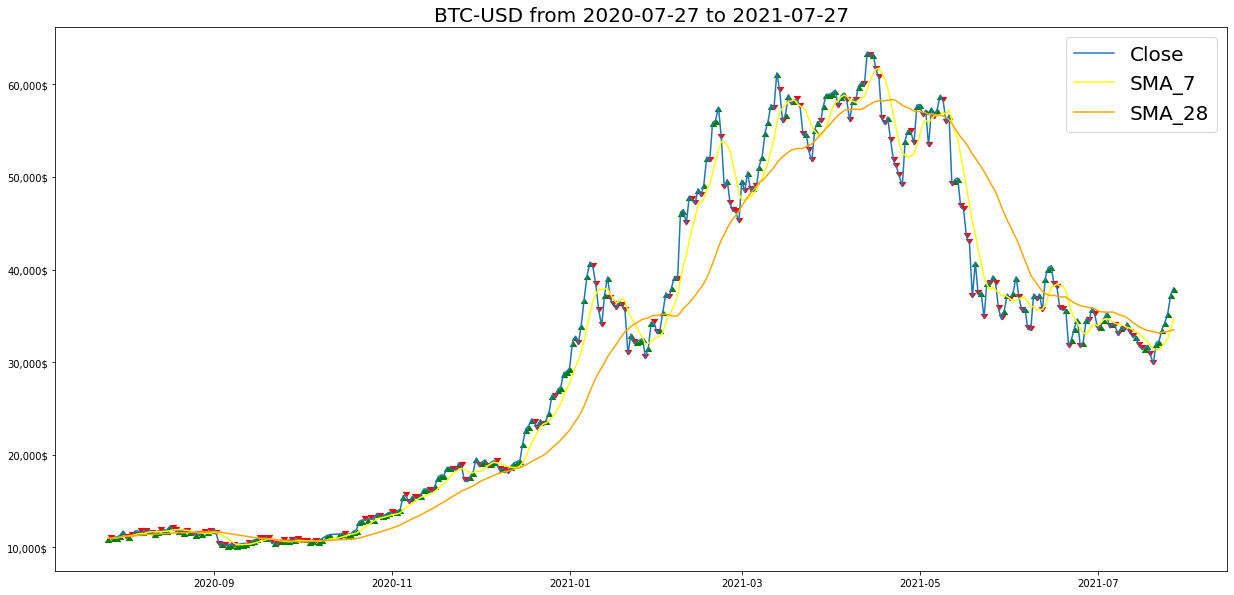

In [82]:
mpl.rcParams['figure.figsize'] = (21, 10)
mpl.rcParams['axes.grid'] = False


fig0, ax = plt.subplots()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}$'))

ax.plot(cc_data.loc[:,'Date'], cc_data.loc[:,'Close'], label = 'Close')
ax.plot(cc_data.loc[:,'Date'], cc_data.loc[:,'SMA_7'],color="YELLOW", label = 'SMA_7')
ax.plot(cc_data.loc[:,'Date'], cc_data.loc[:,'SMA_28'],color="Orange", label = 'SMA_28')
ax.scatter(cc_data.loc[cc_data['up_trend_indicator'] == 1]['Date'],
           cc_data.loc[cc_data['up_trend_indicator'] == 1]['Close'],
           color = "Green",
           marker = 6)
ax.scatter(cc_data.loc[cc_data['up_trend_indicator'] == 0]['Date'],
           cc_data.loc[cc_data['up_trend_indicator'] == 0]['Close'],
           color = "Red" ,
           marker = 7)
ax.set_title((f'{symbol} from {start_date} to {today}'), fontsize = 20)
ax.legend(fontsize=20)

<BarContainer object of 160 artists>

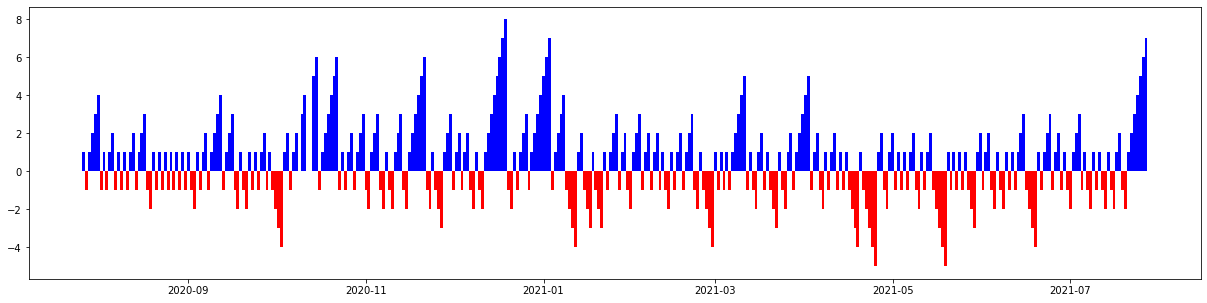

In [83]:
mpl.rcParams['figure.figsize'] = (21, 5)

fig1, ax = plt.subplots()

ax.bar(cc_data.loc[cc_data['up_trend_indicator'] == 1]['Date'],
       (cc_data.loc[cc_data['up_trend_indicator'] == 1]['trend_duration_indicator'])+1, color = 'b', width = 1)
ax.bar(cc_data.loc[cc_data['up_trend_indicator'] == 0]['Date'],
       ((cc_data.loc[cc_data['up_trend_indicator'] == 0]['trend_duration_indicator'])+1)*-1, color = 'r', width = 1)

## 3.4 Asset-based features
---

Since Cryptocurrencies are no closed market, the movement of different financial assets like gold or stock markets could have an important impact on the Crypto market. It can be tedious to analyze all the different possibilities and work out significant correlations maybe even undiscovered short-term causalities. Precisely these can ultimately account for the competitive advantage in the predictions. But there is no question that patterns change, hence an automated and streamlined process is needed to filter relevant inputs.

For example Jaquart et al (2021) are using [MSCI Word returns](https://www.msci.com/real-time-index-data-search), [SNP 500 returns](https://finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC), [Gold returns](https://finance.yahoo.com/quote/GC%3DF?p=GC%3DF), [Crude Oil WTI retruns](https://finance.yahoo.com/quote/CL%3DF?p=CL%3DF), etc.


## 3.5  Blockchain-based features
---

Many blockchain-based features are freely available at [bitinfocharts.com/bitcoin/](https://bitinfocharts.com/bitcoin/). Following are some examples:

*   **Transactions:** The number of sent and received Bitcoin payments
*   **Block size:** Transactional information cryptographically linked in the blockchain.
*   **Block time:** The time required to mine one block.
*   **Hashrate:** The daily total computational capacity of the Bitcoin network.
*   **Difficulty:** The daily average mining difficulty. The difficulty is computed by the network   after a specified number of blocks have been created so that the time it requires
to mine a block remains around 10 min
*   **Median transaction value:** The median value of the transactions in Bitcoin
*   **Avg. transaction value:** The Average value of the transactions in Bitcoin
*   **Median transaction fee:** The median of transaction fees in Bitcoin
*   **Avg. transaction fee:** The average of transaction fees in Bitcoin
*   **etc.**



## 3.6 Sentiment- and interest-based features
---


### 3.6.1 Crypto Fear & Greed Index
---

The crypto market behaviour is very emotional. People tend to get greedy when the market is rising which results in FOMO (Fear of missing out). Also, people often sell their coins in irrational reaction of seeing red numbers. 

A source for the Fear & Greed Index can be for example [alternative.me/crypto/api/](https://alternative.me/crypto/api/). The composition of the index inputs is documented here: [alternative.me/crypto/fear-and-greed-index/](https://alternative.me/crypto/fear-and-greed-index/).

<img src="https://alternative.me/crypto/fear-and-greed-index.png" width="400" alt="Latest Crypto Fear & Greed Index" />


### 3.6.2 Twitter
---

As described by Symeonidis et al (2018) and used by Jaquart et al (2021) the sentiment and further the strength of emotion in regards to bitcoin can be estimated and extracted from tweets via Natural Language Processing. Jaquart et al (2021) used [Google Natural Language API](https://cloud.google.com/natural-language/docs).

Another feature is [Tweets per day](https://bitinfocharts.com/comparison/bitcoin-tweets.html) count for #Bitcoin.








### 3.6.3 Google Trends
---

General interest in Bitcoin via Google queries: [Google Trends - Bitcoin](https://trends.google.com/trends/explore?date=all&q=%2Fm%2F05p0rrx)



